### init, nowをone-hotベクトルで表し、線形モデルで解く

In [3]:
import torch as tc
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def x2vec(x):
    vec = np.zeros(11)
    vec[x] = 1
    return vec

def vec2x(vec):
    return np.argmax(vec)

In [4]:
def next_state(s, a):
#     s0 = s[11:]
    s = vec2x(s)
    if a == 0:
        s_next = s * 2
    elif a == 1:
        s_next = s + 1
    elif a == 2:
        s_next = s
    elif a == 3:
        s_next = s - 1
    elif a == 4:
        s_next = s // 2
    s_next = max(0, min(10, s_next))
    return x2vec(s_next)

In [4]:
# def reward_func(s, n_state, done, T):  # 加藤の実験コードを反映
#     total = 0
#     s = vec2x(s[:11])
#     n_state = vec2x(n_state[:11])
#     if n_state > 10 or n_state < 0:
#         total += -abs(n_state - T)/10
#     diff = abs(T - n_state) - abs(T - s)
#     if diff > 0:
#         total += -3 * diff
#     if done and n_state != T:
#         return -2
#     elif done:
#         loss_reward = 2 * (10 - abs(n_state - T))/10
#         return loss_reward
#     return -0.5 + total

In [17]:
def reward_func(state, n_state, done, T, penalty=-100):
    state = vec2x(state)
    n_state = vec2x(n_state)
    if done:
        if n_state != T:
            return penalty
        return (-1)*penalty
    r = -abs(n_state - T)
    if n_state < 0 or n_state > 10:
        r = r + penalty
    return -1 + r

In [15]:
def step(s, a, T):
    ns = next_state(s, a)
    done = (a == 2)
    r = reward_func(s, ns, done, T)
    return ns, r, done 

$ \frac{\partial L}{\partial a_k} = \sum_{ \{t' \in \{ t | a_t = a_k\}} s_{t'} (s_{t'}^T a_{t'} - v) \qquad (v = r + \gamma max(s_{t' + 1}^T V) )$

In [5]:
def update(Q, batch, lr=0.1, gamma=0.9):
    grad = np.zeros((11, 5))
    for e in batch:
        est = e.s @ Q[:, e.a]
        v = e.r
        if not e.d:
            v += gamma * np.max(e.ns[np.newaxis, :] @ Q)
        grad[:, e.a] += (est - v) * e.s
    Q -= lr * grad

* ある初期値で評価される行動が、どの状態にいても評価されやすい行動になっていることが問題
* ある初期値である事と、ある状態にいる事を合わせて評価できるようにする。   $11dim (init\,state) \times 11dim(now\,state)$クロネッカー積の話  

In [11]:
from collections import defaultdict, namedtuple, deque
import random

def f(x):
    return 5

Experience = namedtuple('Experience', ('s', 'a', 'ns', 'r', 'd'))
starts=[0, 3, 5, 8, 10]
def trial(seed=100, try_num=100000, lr=0.01, eps=0.1):
    # training
    np.random.seed(seed)
    random.seed(seed)
    Q = np.zeros((11, 5))
    R = []
    # each element is [s, a, ns, r, d]
    experiences = deque(maxlen=1024)

    for itr in tqdm(range(try_num)):
        Ri = 0
        s0 = np.random.choice(starts)
        T = f(s0)
        s0 = x2vec(s0)
        # s = np.r_[s0, s0]
        s = s0
        for _ in range(1000):
            # 行動を選択
            a = np.argmax(Q.T @ s) if np.random.rand() >= eps else np.random.randint(5)
            ns, r, d = step(s, a, T)
            e = Experience(s, a, ns, r, d)
            experiences.append(e)
            s = ns
            Ri = Ri + r
            if d:
                break
        if len(experiences) == 1024:
            batch = random.sample(experiences, 32)
            update(Q, batch, lr=lr, gamma=0.9)

        R.append(Ri)
    return Q, R

In [12]:
from scipy.special import softmax
from matplotlib import pyplot as plt
from matplotlib import cm

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

act = ['*2', '+1', 'end', '-1', '/2']
def view(Q, R, n=1000):
    plt.subplot(121)
    plt.plot(moving_average(R, n=n))
    plt.xlabel('# of Trials')
    plt.ylabel('Avg. Reward')

    table = []
    for i in range(11):
        s0 = x2vec(i)
        # s = np.r_[s0, s0]
        s = s0
        u = s.T @ Q
        table.append(softmax(u))
        print('state = %2d, T= %2d, opt_action = %s \t' % (i, f(i), act[np.argmax(u)]), u)

    table = np.array(table)
    ax = plt.subplot(122)
    im = plt.imshow(table, cmap=cm.RdYlGn)
    plt.colorbar(im)
    ax.set_xticks(range(len(act)))
    ax.set_xticklabels(act)

    plt.show()

In [13]:
def test(Q):
    solved = []
    for s0_scalar in range(11):
        T = f(s0_scalar)
        s0_vec = x2vec(s0_scalar)
        # s_vec = np.r_[s0_vec, s0_vec]
        s_vec = s0_vec
        for _ in range(100):
            a = np.argmax(s_vec.T @ Q)
            if a == 2:
                break
            s_vec = next_state(s_vec, a)
        if vec2x(s_vec[:11]) == T:
            solved.append((vec2x(s0_vec[:11]), T, 'solved!'))
        else:
            solved.append((vec2x(s0_vec[:11]), T, '-'))
    for item in solved:
        print('init = %d, T = %d, %s' % item)


state =  0, T=  5, opt_action = +1 	 [ 16.5509614   54.64462225 -78.54760636  23.18504756  26.79909834]
state =  1, T=  5, opt_action = *2 	 [ 66.28643535  53.72158588 -75.53594626  23.81495258  24.88680086]
state =  2, T=  5, opt_action = *2 	 [ 78.09998861  43.8891941  -80.58893916  32.9421173   30.92165917]
state =  3, T=  5, opt_action = +1 	 [ 59.9657235   78.0998889  -80.40086871  34.92013404  28.53407145]
state =  4, T=  5, opt_action = +1 	 [ 63.50016998  89.         -95.07267076  65.2789205   62.26822184]
state =  5, T=  5, opt_action = end 	 [ 73.61077714  74.45092748 100.          76.75021192  63.65779556]
state =  6, T=  5, opt_action = -1 	 [ 39.49979673   7.39964886 -19.83694105  88.47441936  26.78778307]
state =  7, T=  5, opt_action = *2 	 [ 42.37097271   2.26897051 -10.47530975  16.80328457  14.98878532]
state =  8, T=  5, opt_action = /2 	 [ 44.56151535  19.03563806 -68.2302818    9.37911453  78.09995099]
state =  9, T=  5, opt_action = /2 	 [ 13.12221704  14.3531592

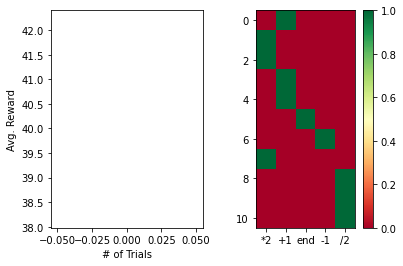

****************************************************************************************************
init = 0, T = 5, solved!
init = 1, T = 5, solved!
init = 2, T = 5, solved!
init = 3, T = 5, solved!
init = 4, T = 5, solved!
init = 5, T = 5, solved!
init = 6, T = 5, solved!
init = 7, T = 5, solved!
init = 8, T = 5, solved!
init = 9, T = 5, solved!
init = 10, T = 5, solved!


In [19]:
Q, R = trial(seed=0, eps=0.3, try_num=1000)
view(Q, R, n=1000)
print('*' * 100)
test(Q)

In [11]:
for i, row in enumerate(Q):
    if i <=10:
        print('now', i, row)
    else:
        print('init', i - 11, row)

now 0 [ 1.48570906 -0.27976251  1.4449973  -0.08544913  0.2092673 ]
now 1 [ 1.41726196  0.53539375 -0.39556075 -2.0721071  -0.30631553]
now 2 [-0.8542866  -1.10453443  0.36121413 -2.61841442 -0.80220367]
now 3 [-1.08231045 -0.49784632 -0.52962373 -0.35593717 -0.936613  ]
now 4 [-3.46932988 -0.55504033 -0.91480138 -0.34203894 -1.15250387]
now 5 [-6.78309893 -0.71751632  0.86809269 -0.29134722 -3.41778317]
now 6 [-4.89520024 -0.64224554 -0.77834816 -0.22242621 -2.20786239]
now 7 [-4.96885145 -0.881326    1.57671987 -0.20771329 -2.03704378]
now 8 [-1.67441935 -1.28197824 -0.29155592 -0.21340776 -0.80522758]
now 9 [-0.48435354 -1.27642095 -0.36765392 -0.26645032 -1.92896839]
now 10 [ 1.24912631 -0.28035743  1.10016858 -0.29240186 -3.68778269]
init 0 [-1.75288043 -0.10389586 -2.4379991  -1.89433028 -5.36402274]
init 1 [0. 0. 0. 0. 0.]
init 2 [0. 0. 0. 0. 0.]
init 3 [-1.48518625 -0.07619834 -1.62265389 -2.0575872  -3.84389933]
init 4 [0. 0. 0. 0. 0.]
init 5 [-8.48425977 -2.52476222 10.545286

In [96]:
# init = 0の時の値は常にこれ
now_i = 3
init_i = 14
print(act)
print(Q[now_i])
print('+')
print(Q[init_i])
total_q = Q[now_i] + Q[init_i]
print('\t=', total_q)
print('action_index = ', np.argmax(total_q), ', action = ', act[np.argmax(total_q)])

['*2', '+1', 'end', '-1', '/2']
[-0.77085288 -0.55617925  1.64425066 -1.82115445 -0.42672944]
+
[0. 0. 0. 0. 0.]
	= [-0.77085288 -0.55617925  1.64425066 -1.82115445 -0.42672944]
action_index =  2 , action =  end


In [104]:
# 0, 10の奇跡を追ってみる
done = False
max_iter = 10
init = 3
print('T =', f(init))
print('*' * 10)
s0_v = x2vec(init)
print(s0_v)
s_v = np.r_[s0_v, s0_v]
print(np.arange(22)[s_v.astype(np.bool)], 'h')
for i in range(max_iter):
    a = np.argmax(s_v.T @ Q)
    if a == 2:
        break
    print(vec2x(s_v[:11]), act[a])
    s_v = next_state(s_v, a)
print(vec2x(s_v[:11]))

T = 7
**********
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[ 3 14] h
3 +1
4 +1
5 +1
6 +1
7 +1
8 +1
9 +1
10 *2
10 *2
10 *2
10


# 結果

### 条件１
スッテプごとの更新をしてた時期
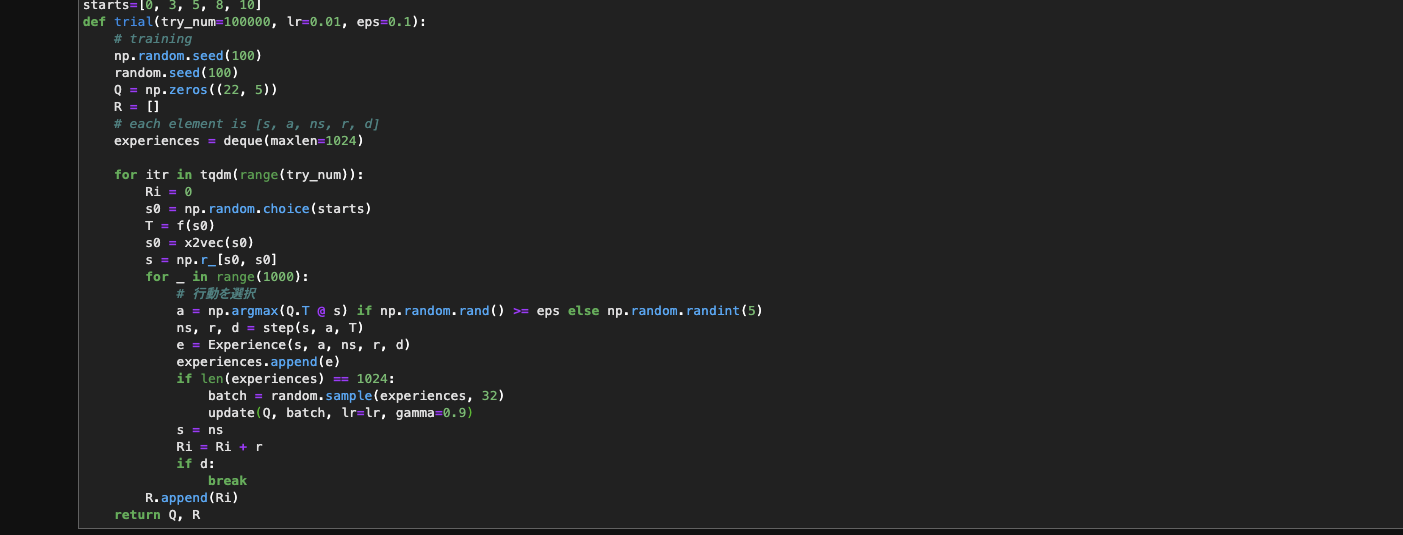

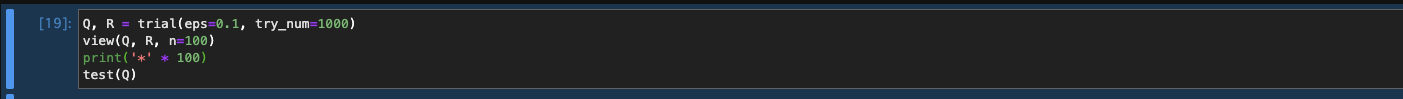

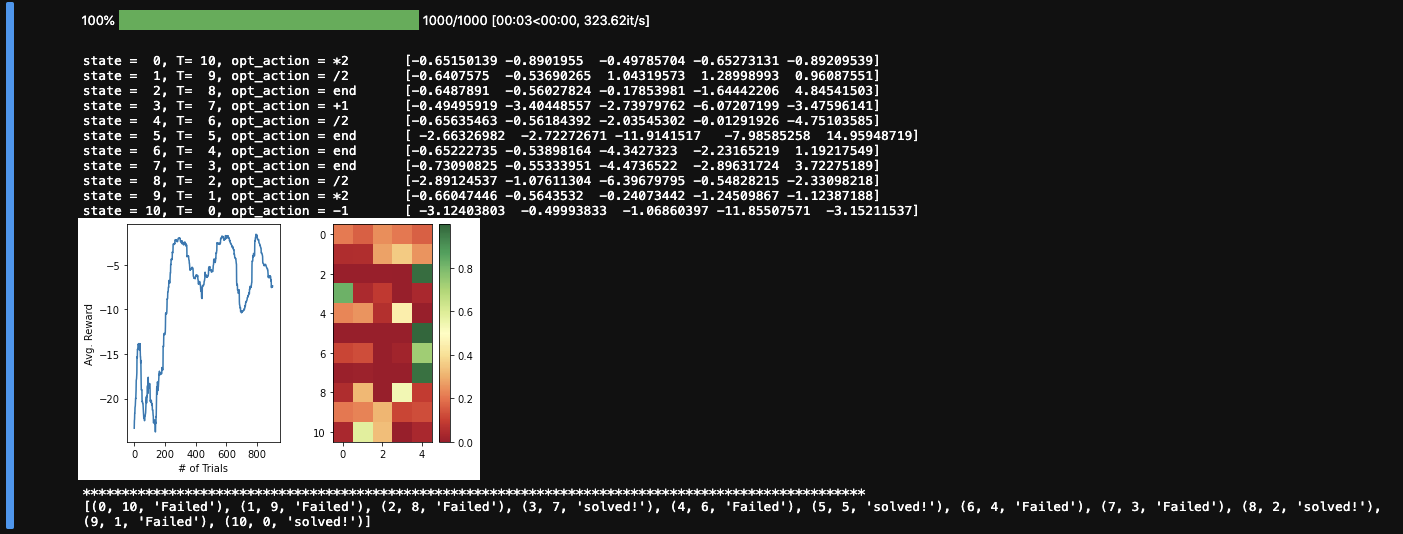

### 条件２
エピソード終了時に更新するようにしたら解けた
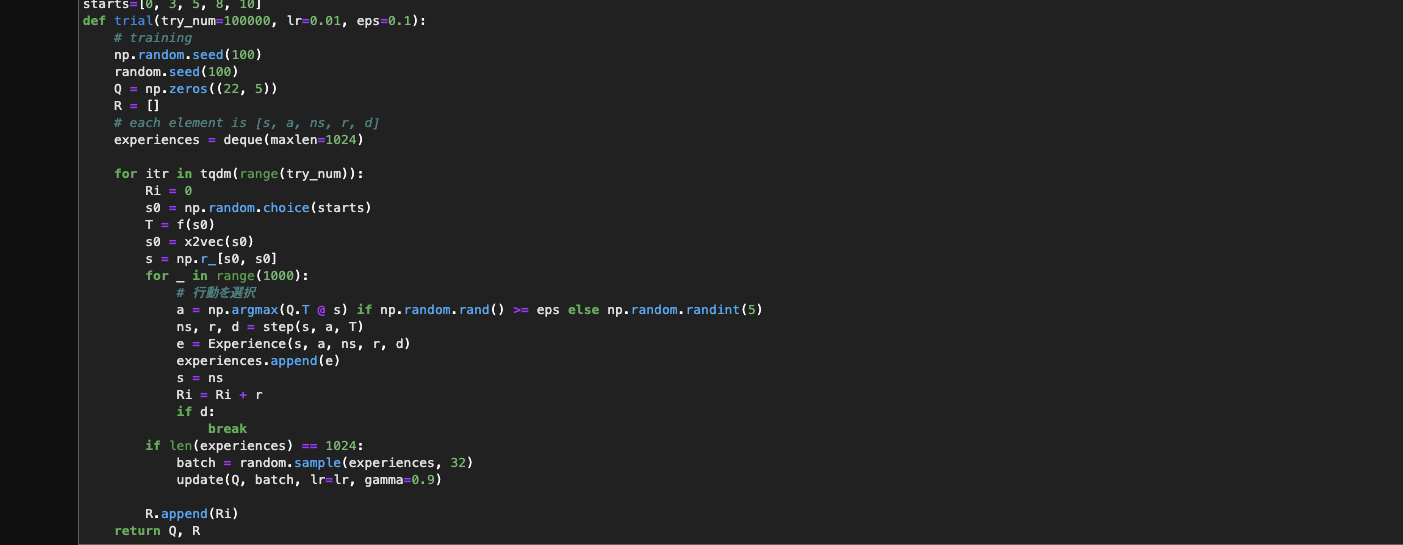

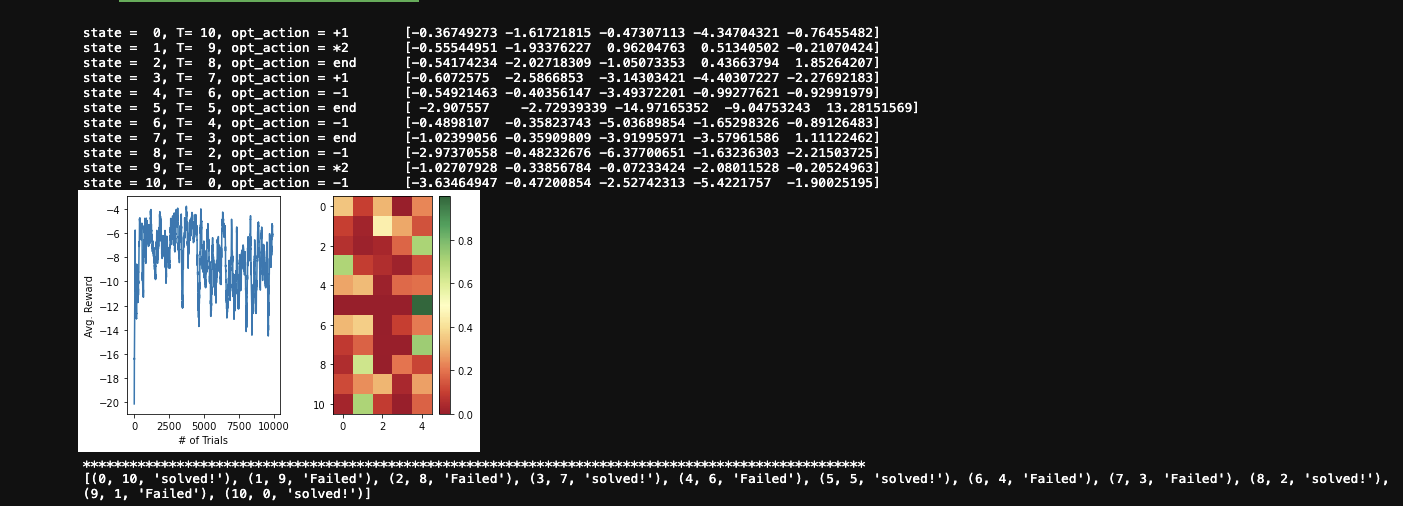

### 謎(と思った)出来事
行動の順番を+1, -1, *2, /2, end から *2, +1, end, -1, /2に変えたら、0, 10が解けなくなった
-> 確率epsilonで疑似乱数生成器から得られる値の意味が変わるので同じ結果にはなるはずがない
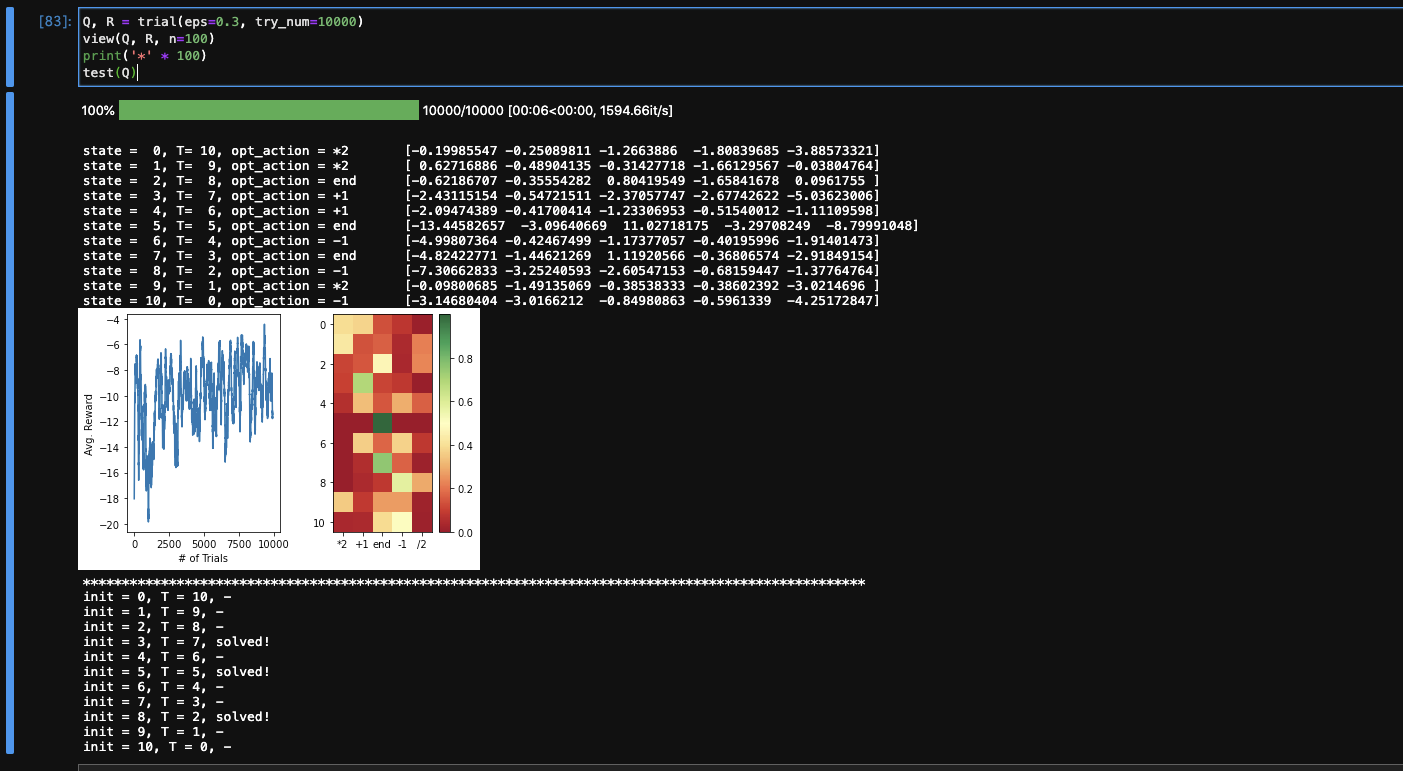
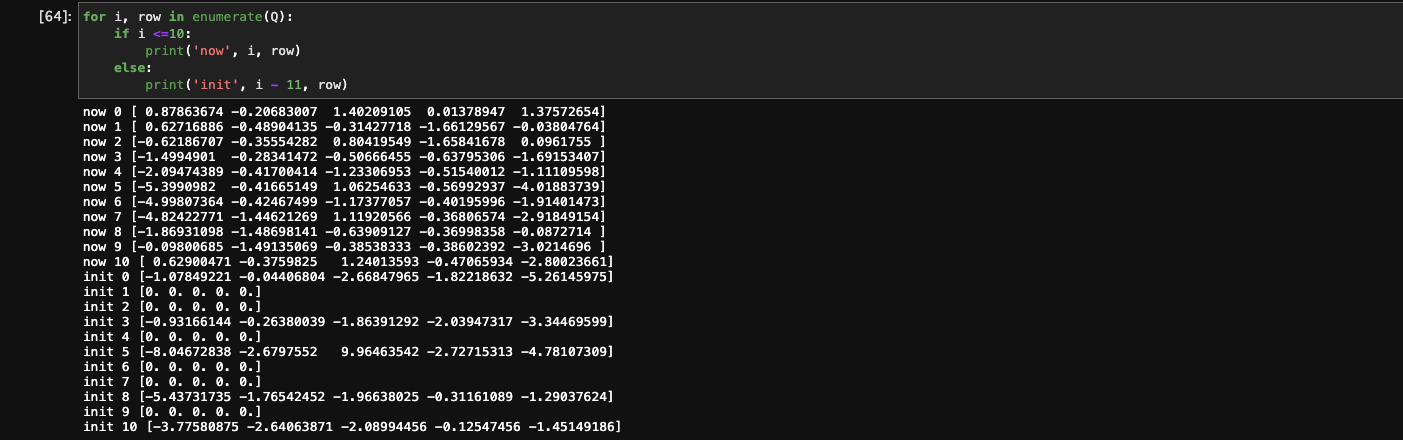
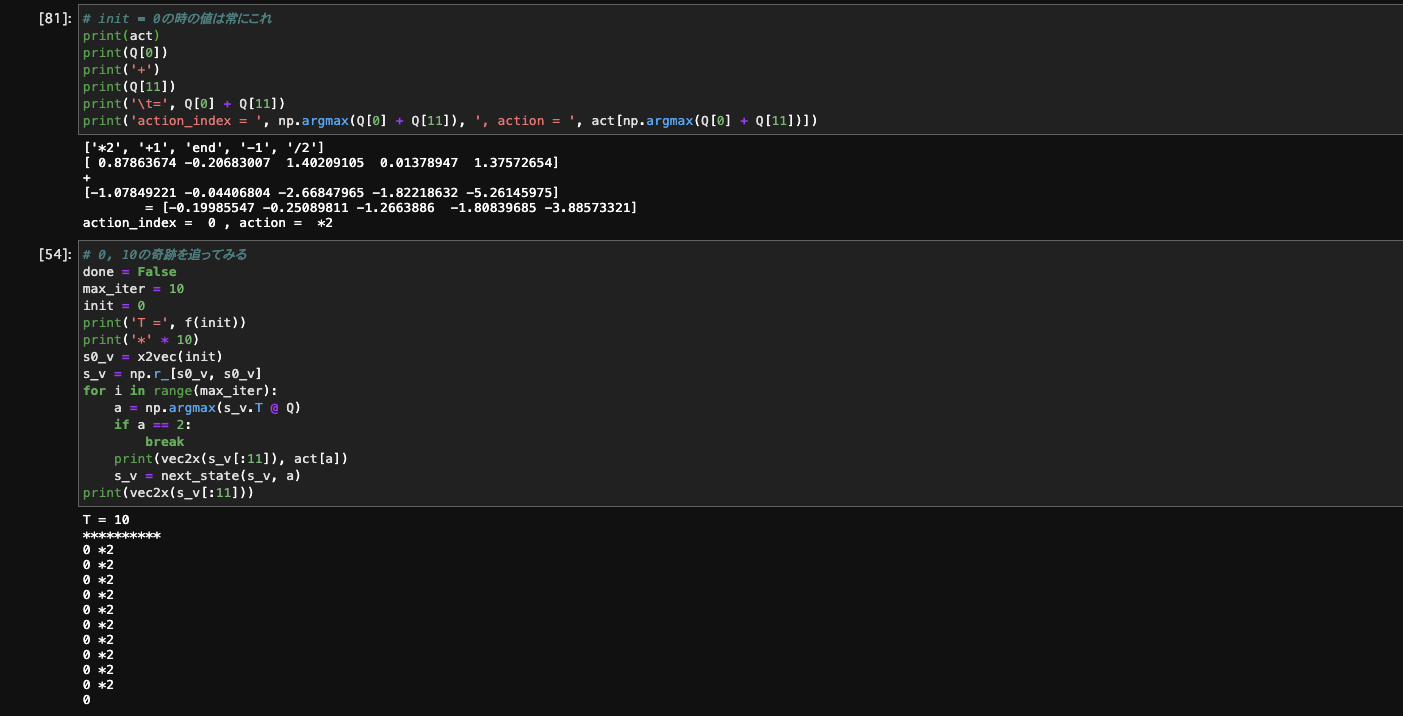